In [45]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,List,Dict,Optional,Literal
import json
import re
from pydantic import BaseModel,Field


In [46]:
model=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [47]:
class QuizItem(BaseModel):
    question:str
    answer:str
    options:List[str]

class StudyPlan(TypedDict):
    start_date:str
    end_date:str
    daily_plan:Dict[str,str]

class FeedbackItem(TypedDict):
    score: int
    suggestions: List[str]
    next_focus: List[str]

class StudyAssisstant(TypedDict):
    query: str
    topic:str
    count:int
    decision:Literal['study_plan','quiz','another']
    quiz: Optional[List[QuizItem]]
    plan: Optional[StudyPlan]
    feedback: Optional[FeedbackItem]
    optional: Optional[str]
    score:int

In [48]:
# structured_model=model.with_structured_output([QuizItem])

In [36]:


def quiz_planner(state:StudyAssisstant):
    topic=state['topic']
    count=state['count']
    print(topic)
    print(count)
    prompt = """
You are a helpful and intelligent quiz generator.

Your task is to create a quiz based on the topic: **{topic}**
Number of questions to generate: {count}

Return the result as a JSON object with this format:
{
  "items": [
    {
      "question": "...",
      "answer": "...",
      "options": ["...", "...", "...", "..."]
    }
  ]
}
"""
    response = model.invoke(prompt)
    content = response.content.strip()
    print(content)
    # # Remove outer triple backticks and `json` label
    # content = re.sub(r"```json|```", "", content).strip()
    content=re.sub(r"```json|```","",content)
    # Remove **inner** triple backticks inside question strings
    content = re.sub(r"```python\n?|```", "", content)
    items=[]
    try:
        data = json.loads(content)
        items = data["items"]
        print("Parsed items:", items)
    except json.JSONDecodeError as e:
        print("JSON Decode Error:", e)
        print("Cleaned content:\n", content)
    
    return items


In [ ]:
def study_plan(state:StudyAssisstant):
    topic =state['topic']
    prompt = f"""
You are an expert AI assistant that generates effective and realistic study plans for students.

Generate a detailed 7-day study plan for the topic: "{topic}".

Your output **must be** in the following JSON format:
{{
  "start_date": "YYYY-MM-DD",
  "end_date": "YYYY-MM-DD",
  "daily_plan": {{
    "Day 1": "Introduction to the topic...",
    "Day 2": "Deep dive into concept A...",
    ...
    "Day 7": "Revision and practice"
  }}
}}

Rules:
- Start from today’s date as start_date.
- The plan should span 7 days.
- Use simple and clear language.
- Do **not** include any explanation or text outside the JSON format.

Now generate the study plan.
"""

    response=model.invoke(prompt)

    content=re.sub(r"```json|```","",response.content)
    
    return content


In [53]:
study_plan({"topic":"Help me plan a study schedule for dynamic programming"})

Help me plan a study schedule for dynamic programming

{
  "start_date": "2024-10-27",
  "end_date": "2024-11-02",
  "daily_plan": {
    "Day 1": "Introduction to Dynamic Programming: What is DP?  Key concepts: Optimal substructure and overlapping subproblems.  Solve simple examples like Fibonacci sequence.",
    "Day 2": "Memoization: Top-down approach. Implement memoization in a simple problem (e.g., Fibonacci). Practice coding problems involving memoization.",
    "Day 3": "Tabulation: Bottom-up approach.  Understand the difference between memoization and tabulation. Solve problems using tabulation (e.g., finding the nth Fibonacci number).",
    "Day 4": "DP on sequences:  Learn about common DP problems on sequences like Longest Common Subsequence (LCS), Longest Increasing Subsequence (LIS), and Edit Distance. Solve practice problems for each.",
    "Day 5": "DP on grids: Explore problems involving grids, such as 0/1 Knapsack, Matrix Chain Multiplication, and shortest path problems 

In [50]:
def topic_extracter(state: StudyAssisstant):
    query = state['query']
    prompt = f"""
You are an intelligent assistant designed to classify and extract structured information from user study-related queries.

Given the following user query:
query: "{query}"

Your task is to analyze the intent and return a structured response with the following format:

- decision: Literal['study_plan', 'quiz', 'another']

Interpretation rules:
1. If the query is about preparing or taking a quiz/test:
   - decision: 'quiz'
   - topic: Identify the main topic or subject of the quiz (e.g., "binary trees", "OS scheduling").
   - count: Extract the number of quiz questions requested (e.g., "give me 5 questions"), or return a default value of 10 if not specified.

2. If the query is about planning or organizing a study session:
   - decision: 'study_plan'
   - topic: Identify the primary subject or concept the user wants to study.

3. If the query does not fall under 'quiz' or 'study_plan':
   - decision: 'another'
   - query: Return an enhanced and more specific version of the original query to help guide the user toward a better-defined study action.

Be concise, accurate, and avoid assumptions unless logically inferred from the query.
"""


    response=model.invoke(prompt)

    
    content=re.sub("```json","",response.content)
    content=re.sub("```","",content)
    obj=json.loads(content)
    

    return obj


In [40]:
def check(state:dict)->Literal["quiz_planner", "study_plan", "another"]:

    if state['decision']=="quiz":
        return "quiz_planner"
    elif state['decision']=='study_plan':
        return "study_plan"
    else:
        return "another"

In [41]:
def another(state:StudyAssisstant):
    pass

In [59]:
def feedback(state: StudyAssisstant):
    prompt = f"""
You are an intelligent academic assistant providing feedback on a user's quiz performance.

Topic: {state["topic"]}
Score: {state["score"]} out of {state['count']}

Your task:
- Analyze the user's score and provide constructive, personalized feedback.
- If the score is low, highlight weak areas and suggest specific subtopics to revise.
- If the score is average, suggest reinforcement and practice strategies.
- If the score is high, praise the performance and recommend advanced or related topics to explore.
- Offer 2–3 practical study suggestions to improve or go deeper.
- Keep the tone encouraging and helpful.

Be concise but informative.
"""
    response=model.invoke(prompt)

    return {'feedback':response.content}
    


Congratulations on scoring 7 out of 10 on your Python quiz! That's a good start, showing a solid understanding of the fundamentals.  To build on this success, I suggest focusing on reinforcing your knowledge in the areas where you may have lost points.  Reviewing concepts related to those questions (perhaps focusing on specific functions or data structures involved) would be beneficial.  Consider working through more practice problems, focusing on those areas you found challenging.  Finally, exploring more advanced topics like list comprehensions or working with external libraries (like `requests` for web scraping, or `pandas` for data analysis) will deepen your Python expertise.


In [60]:
graph = StateGraph(StudyAssisstant)
graph.add_node("topic_extracter", topic_extracter)
graph.add_node("quiz_planner", quiz_planner)
graph.add_node("study_plan", study_plan)
graph.add_node("another", another)
graph.add_node('feedback',feedback)
graph.add_edge(START, "topic_extracter")
graph.add_conditional_edges("topic_extracter", check)
graph.add_edge("quiz_planner", 'feedback')
graph.add_edge('feedback',END)
graph.add_edge("another", END)
graph.add_edge("study_plan", END)

workflow = graph.compile()


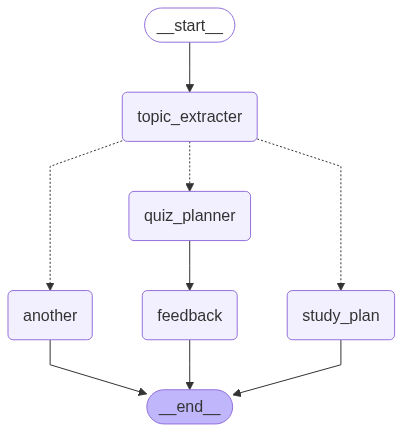

In [61]:
workflow

In [55]:
workflow.invoke({"query":"Help me plan a study schedule for dynamic programming"})

dynamic programming

{
  "start_date": "2024-10-27",
  "end_date": "2024-11-02",
  "daily_plan": {
    "Day 1": "Introduction to Dynamic Programming: What is it?  When to use it? Examples of DP problems (Fibonacci, Knapsack). Watch introductory videos and read basic explanations.",
    "Day 2": "Memoization: Implementing memoization in code. Practice problems involving simple recursive solutions that can be optimized with memoization. Focus on understanding the time and space complexity improvements.",
    "Day 3": "Tabulation: Understanding the tabulation approach.  Convert memoization solutions to tabulation. Practice problems focusing on tabulation implementation.  Compare and contrast memoization and tabulation.",
    "Day 4": "Common DP Patterns: Explore common patterns like 0/1 Knapsack, Longest Common Subsequence (LCS), Longest Increasing Subsequence (LIS). Work through examples of each pattern.",
    "Day 5": "Advanced DP Problems: Tackle more challenging problems involving the

{'query': 'Help me plan a study schedule for dynamic programming',
 'topic': 'dynamic programming',
 'decision': 'study_plan'}